# Assignment 1

In this assignment you will build a document classification model for a [Hate Speech Detection dataset](https://aaai.org/ocs/index.php/ICWSM/ICWSM17/paper/view/15665). Note that this dataset contains some strong and offensive language, and exists to partially automate the real-world task of fighting hatespeech online.

You will train models on the available training set and can tune them on the development set. After submission we will run your notebook on a different test set. Your mark will depend on:

* the intuition behind the **model and features** selected for your approach,
* its **accuracy** on the test set we will use

To develop your model you have access to:

* The data in `data/hatespeech/`. Remember to un-tar the data.tar.gz file.
* The code of the lectures, stored in the notebooks [here](https://github.com/copenlu/stat-nlp-book/blob/master/chapters/doc_classify_slides_short.ipynb) and [here](https://github.com/copenlu/stat-nlp-book/blob/master/chapters/dl-representations.ipynb).
* Libraries on the [docker image](https://github.com/copenlu/stat-nlp-book/blob/master/Dockerfile) which contains everything in [this image](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook), including scikit-learn and tensorflow. 

As we have to run the notebooks of all students, and because writing efficient code is important, **your notebook should run in 10 minutes at most, including package loading time**, on your machine. Further comments:

* You are expected to **use and contrast lexical features from Lecture 1** with **representation learning based methods from Lecture 2**.

* You are encouraged to read the background material linked in the lecture notebook for inspiration.

* Try to run your parameter optimisation offline, such that in your answer notebook the best parameters are already set and don't need to be searched.

* If you use any large pre-trained models as part of your approach, please state what these are in the relevant section below and add code for downloading these resources from an externally hosted repository.

* We will not assess the stylistic aesthetics of your code or description, but rather, respectively, that it works and is easily understandable.

* You are free to explore using GPUs during development, but the solution you submit should not be a GPU-only solution (i.e. it needs to run on a CPU within the time limit).

## Setup Instructions
It is important that this file is placed in the **correct directory**. It will not run otherwise. The correct directory is

    DIRECTORY_OF_YOUR_BOOK/assignments/2019/assignment1/problem/
    
where `DIRECTORY_OF_YOUR_BOOK` is a placeholder for the directory you downloaded the book to. After you placed it there, **rename the file** to your UCPH ID (of the form `xxxxxx`). 

## General Instructions
This notebook will be used by you to provide your solution, and by us to both assess your solution and enter your marks. It contains three types of sections:

1. **Setup** Sections: these sections set up code and resources for assessment. **Do not edit these**. 
2. **Assessment** Sections: these sections are used for both evaluating the output of your code, and for markers to enter their marks. **Do not edit these**. 
3. **Task** Sections: these sections require your solutions. They may contain stub code, and you are expected to edit this code. For free text answers simply edit the markdown field.  

Note that you are free to **create additional notebook cells** within a task section. 

**Do not share** this assignment publicly, by uploading it online, emailing it to friends etc. 

**Do not** copy code from the Web or from other students, this will count as plagiarism.

## Submission Instructions

To submit your solution:

* Make sure that your solution is fully contained in this notebook. 
* **Rename this notebook to your UCPH ID** (of the form "xxxxxx"), if you have not already done so.
* Download the notebook in Jupyter via *File -> Download as -> Notebook (.ipynb)*.
* Upload the notebook to Absalon.


## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change it.**

In [1]:
#! SETUP 1
import sys, os
_snlp_book_dir = "../../../../"
sys.path.append(_snlp_book_dir) 
import math
from os import listdir
from os.path import isfile, join
import statnlpbook.util as util
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib style options
plt.rcParams['figure.figsize'] = (20.0, 6.0)
plt.style.use('ggplot')

## <font color='green'>Setup 1.1</font>: Load Additional Packages

In [2]:
from math import log, exp
import copy
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import grid_search
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from collections import Counter

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## <font color='green'>Setup 2</font>: Load Training Data

This cell loads the training data. We use this data for assessment to define the reference vocabulary: the union of the words of the training and test set. You can use the dataset to train your model, but you are also free to load the data in a different way, or focus on subsets etc. However, when you do this, still **do not edit this setup section**. Instead refer to the variables in your own code, and slice and dice them as you see fit.   

In [3]:
#! SETUP 2

import re

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase. Returns a list of tokens."""
    tokens = re.split("[^a-zA-Z]+", tweet.lower().strip())
    return tokens

def load_hatespeech(directory, fname):
    """
    Load tweets from the given file (train,dev,test).csv.
    Params:
        directory: the directory to load the documents from.
        split: the split to load
    Returns:
        a list of (x,y) pairs where x is a tokenised tweet, and y is the label.
    """
    data = []
    with open(os.path.join(directory, fname), 'r') as in_f:
        for line in in_f:
            fields = line.split(',')
            if len(fields) != 2:
                print(fields)
            label = fields[0]
            tokens = tokenize(fields[1])
            data.append((tokens,label))

    return data
 
train = load_hatespeech(os.path.join(_snlp_book_dir + 'data/hatespeech/'), 'train.csv') 
dev = load_hatespeech(os.path.join(_snlp_book_dir + 'data/hatespeech/'), 'dev.csv')
test = load_hatespeech(os.path.join(_snlp_book_dir + 'data/hatespeech/'), 'dev.csv')

Due to file encoding issues this code produces one error `Could not load ...`. **Ignore this error**.

## Pre processing

In [4]:
def filter_data(data):
    data_copy = copy.deepcopy(data)
    for i in range(len(data_copy)):
        for j in range(len(data_copy[i][0])):
            data_copy[i][0][j] = preprocess(data_copy[i][0][j])
        if 'http' in data_copy[i][0]:
            data_copy[i][0].remove('http')
        else: 
            pass
        if '' in data_copy[i][0]:
            data_copy[i][0].remove('')
        else:
            pass
    return data_copy

In [5]:
train_filtered = filter_data(train)
dev_filtered = filter_data(dev)

### Removing stop words

In [6]:
stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the'] + list(string.punctuation))

In [7]:
def remove_stopwords(data):
    data_copy = copy.deepcopy(data)
    return [([w for w in x if w not in stop_words],y) for x,y in data_copy]

In [8]:
train_filtered = remove_stopwords(train_filtered)
dev_filtered = remove_stopwords(dev_filtered)

## <font color='blue'>Task 1</font>: Explore the data

Note that class 0 denotes Hatespeech, class 1 denotes offensive speech, and class 2 denotes neither.

1.1. What is the average length of a tweet (n tokens) in the training set? 

1.2. What is the class balance in your training and development sets?

1.3. What is the number of types and tokens in the training data? 

1.4. What is the vocabulary overlap between train and dev data?

1.5. Visualize the frequency of unigrams and bigrams across the training data. If necessary, you may limit the number of uni/bigrams you plot to the N most frequent, e.g., if the plot takes a long time to be generated.

1.6. How does this task compare to Sentiment Analysis? How are the problems similar, which task is more/less challenging, and why?

In [9]:
df_train = pd.DataFrame(train_filtered, columns = ['document' , 'class'])
df_dev = pd.DataFrame(dev_filtered, columns = ['document' , 'class'])

In [10]:
print(color.BOLD + 'First five rows of the training set:' + color.END)
df_train.head()

First five rows of the training set:


,document,class
0,"[rt, chanseydarapper, make, way, right, trash,...",2
1,"[stunningvisual, yes, hoe, always, camera, ]",1
2,"[rt, yepitstrey, like]",1
3,"[dudes, edwards, cait, calling, bitches, left,...",1
4,"[souljaboy, kmichelle, ur, pussy, smell, like,...",1


In [11]:
print(color.BOLD + 'First five rows of the development set:' + color.END)
df_dev.head()

First five rows of the development set:


,document,class
0,"[niggas, pure, pussy, see, faces]",1
1,"[dog, lifted, leg, pee, butch, bitch]",1
2,"[dcc, bitches, knocked, grass]",1
3,"[chloeonvine, kidding, right, co, lfsvymmqtn, ...",1
4,"[rt, chiefkeef, dat, bitch, katy, perry, suck,...",0


#### <font color='blue'>Task 1.1.</font>: What is the average length of a tweet (n tokens) in the training set?

In [12]:
df_train['n_tokens'] = df_train['document'].apply(len)
average = df_train['n_tokens'].mean()
print("Average lenght of a document in the training set is: %.2f" %(average))

Average lenght of a document in the training set is: 8.21


In [13]:
print("Average length of hate speech document:", df_train[df_train['class'] == '0']['n_tokens'].mean())
print("Average length of offensive speach document:", df_train[df_train['class'] == '1']['n_tokens'].mean())
print("Average length of neither hate speech or offensive speach document:", df_train[df_train['class'] == '2']['n_tokens'].mean())

Average length of hate speech document: 8.3572695035461
Average length of offensive speach document: 8.089310142661716
Average length of neither hate speech or offensive speach document: 8.718523002421307


#### <font color='blue'>Task 1.2.</font>: What is the class balance in your training and development sets?

In [14]:
#Training set
H1 = len(df_train[df_train['class'] == '0'])
O1 = len(df_train[df_train['class'] == '1'])
N1 = len(df_train[df_train['class'] == '2'])

#Development set
H2 = len(df_dev[df_dev['class'] == '0'])
O2 = len(df_dev[df_dev['class'] == '1'])
N2 = len(df_dev[df_dev['class'] == '2'])

print(color.BOLD + 'Class balance in the training set:' + color.END)
print("Number of hate speech documents:  {0} ({1:2.2f}%)".format(H1, (H1/ (H1 + O1 + N1))*100))
print("Number of offensive speach documents:  {0} ({1:2.2f}%)".format(O1, (O1/ (H1 + O1 + N1))*100))
print("Number of neither hate speech or offensive speach documents:  {0} ({1:2.2f}%)".format(N1, (N1/ (H1 + O1 + N1))*100))

print("\n")

print(color.BOLD + 'Class balance in the development set:' + color.END)
print("Number of hate speech documents:  {0} ({1:2.2f}%)".format(H2, (H2/ (H2 + O2 + N2))*100))
print("Number of offensive speach documents:  {0} ({1:2.2f}%)".format(O2, (O2/ (H2 + O2 + N2))*100))
print("Number of neither hate speech or offensive speach documents:  {0} ({1:2.2f}%)".format(N2, (N2/ (H2 + O2 + N2))*100))

Class balance in the training set:
Number of hate speech documents:  1128 (5.70%)
Number of offensive speach documents:  15351 (77.60%)
Number of neither hate speech or offensive speach documents:  3304 (16.70%)


Class balance in the development set:
Number of hate speech documents:  153 (6.12%)
Number of offensive speach documents:  1927 (77.08%)
Number of neither hate speech or offensive speach documents:  420 (16.80%)


#### <font color='blue'>Task 1.3.</font>: What is the number of types and tokens in the training data?

In [15]:
full_list_train = [i for sublist in list(df_train['document']) for i in sublist]
no_types = len(set(full_list_train))
no_tokens = len(full_list_train)

print("The number of types in the training data is: %d" %(no_types))
print("The number of tokens in the training data is: %d" %(no_tokens))

The number of types in the training data is: 27877
The number of tokens in the training data is: 162412


#### <font color='blue'>Task 1.4.</font>: What is the vocabulary overlap between train and dev data?

In [16]:
full_list_dev = [i for sublist in list(df_dev['document']) for i in sublist]

set_train = set(full_list_train)
set_dev = set(full_list_dev)
overlap = len(set_train.intersection(set_dev))

print("The vocabulary overlap between the training and development set is: %d" %(overlap))

The vocabulary overlap between the training and development set is: 4488


##### <font color='blue'>Task 1.5.</font>: Visualize the frequency of unigrams and bigrams across the training data. If necessary, you may limit the number of uni/bigrams you plot to the N most frequent, e.g., if the plot takes a long time to be generated.

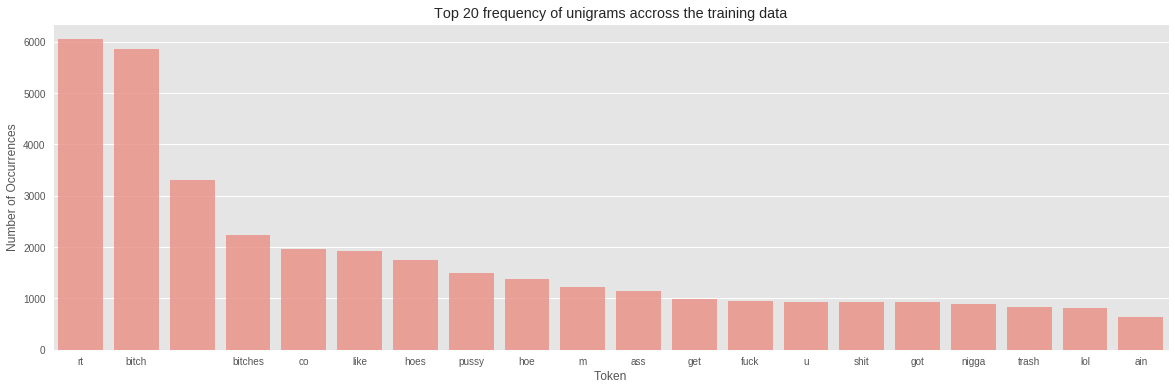

In [17]:
series = pd.DataFrame(full_list_train,columns = ['token'])
token_count  = series['token'].value_counts()
token_count = token_count[:20,]

sns.barplot(token_count.index, token_count.values, alpha=0.8, color="salmon")
plt.title('Top 20 frequency of unigrams accross the training data')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Token', fontsize=12)
plt.show()

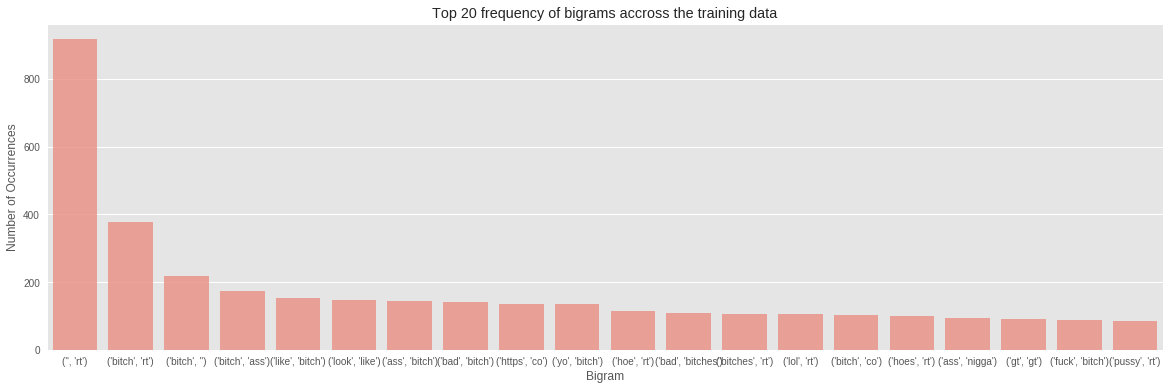

In [18]:
seq = list(series['token'])
bigrams = Counter(zip(seq, seq[1:]))
df_bigrams = pd.DataFrame.from_dict(bigrams, orient='index').reset_index()
df_bigrams.columns = ['bigram','freq']
df_bigrams = df_bigrams.sort_values(by=['freq'], ascending=False)
top20_bigram = df_bigrams.head(20)

sns.barplot(top20_bigram['bigram'], top20_bigram['freq'], alpha=0.8, color="salmon")
plt.title('Top 20 frequency of bigrams accross the training data')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Bigram', fontsize=12)
plt.show()

#### <font color='blue'>Task 1.6.</font>: How does this task compare to Sentiment Analysis? How are the problems similar, which task is more/less challenging, and why?

import gensim

## <font color='red'>Assessment 1</font>: Assess data analysis (10 pts) 

We will mark the description along the following dimensions: 

* Substance (10pts: Well motivated answers to each of the questions. 1.1-1.4: Max 1.5 point per question. 1.5-1.6: Max 2 points per question.)

## <font color='blue'>Task 2</font>: Develop and Train the Model

This is the core part of the assignment. You are to implement, train and tune a hatespeech detection model. You can use some of the existing text analysis model code developed in the lecture, or develop your own extensions. 

Concretely, you need to return a hatespeech detection model in the `create_hs_model` function, and code to make predictions with this model in the `make_hs_predictions` function. This function receives a dataset `data`, and it needs to return a hatespeech detection model defined over that data. You will also need to adapt a function that takes as input the hatespeech detection model and a test dataset, 
and return a label for each instance.
The format of the test set is the same as the output of `load_hatespeech` above.
The label should correspond to those from the training and dev sets.

For the model you develop in this task, you should use and contrast different lexical features, as explained in the [lecture on text classification](https://github.com/copenlu/stat-nlp-book/blob/master/chapters/doc_classify_slides_short.ipynb) as well as associated further readings.

## Logistic Regression

In [19]:
import numpy as np
from collections import defaultdict
word2id = defaultdict(lambda: len(word2id)+1)
def create_hs_model(train_data, dev_data):
    
    train_data = filter_data(train_data)
    train_data = remove_stopwords(train_data)
    
    vectorizer = CountVectorizer(preprocessor = lambda x: x, tokenizer = lambda x: x)
    train_x = vectorizer.fit_transform([x for x,_ in train_data])

    train_y = [int(y) for _,y in train_data]    
    
    lr = LogisticRegression(penalty = 'l2', C = 1.623776739188721, solver = 'sag')
    lr.fit(train_x, train_y)
    print(lr)
    
    return (lr, vectorizer)
def make_hs_predictions(hs_model, test_data):
    
    lr, vectorizer = hs_model
    
    filter_data(test_data)
    remove_stopwords(test_data)
    
    test_x = vectorizer.transform([x for x,_ in test_data])
  
    lr_guess = lr.predict(test_x)
    guess = [str(y) for y in lr_guess]
    
    return guess

## <font color='red'>Assessment 2</font>: Apply to Test Data (20 pts)


We assess how well your model performs on an unseen test set. 

* 0-5 pts: performance close to that of the unigram model presented in the lecture
* 5-15 pts: in between
* 15-20 pts: performance close to best result achieved on dataset


In [20]:
hs_model = create_hs_model(train,dev)
predictions = make_hs_predictions(hs_model, test)

def accuracy(data, guess):
    correct = 0
    for (x,y),y_guess in zip(data,guess):
        if y_guess == y:
            correct += 1
    return correct / len(data)

accuracy(test, predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)


0.8716

The above solution is marked with **
<!-- ASSESSMENT 3: START_POINTS -->
0
<!-- ASSESSMENT 3: END_POINTS --> points**. 

## <font color='blue'>Task 3</font>: Use distributional features

Add distributional features to the model, for instance by encoding sentences using word embeddings, or use sentence representations on which you fit your model. An example of this will be released with Lecture 2.

Approach
- from word to sentence to document representation
- use a simple bag-of-words (BoW) representation on a single word level (1-grams). 
- sklearn.feature_extraction.text.CountVectorizer convert the whole corpus to a document-term matrix of size N x M, where N is a number of documents (tweets), M is a vocabulary size (number of different words in the corpus)
- each element d_ij corresponds to the number (or frequency, or tf-idf, etc) of the word j in the document i.
- As each document is usually far from containing all the words from vocabulary, the matrix is usually very sparse (has a lot of 0's)

In [21]:
def to_dict(x):
    result = defaultdict(float)
    for w in x:
        result[w] += 1.0
    return result

In [22]:
import numpy as np
from collections import defaultdict
word2id = defaultdict(lambda: len(word2id)+1)
def create_distributional_hs_model(train_data, dev_data):
    
    train_data = filter_data(train_data)
    train_data = remove_stopwords(train_data)
    
    vectorizer = DictVectorizer()
    to_tfidf = TfidfTransformer()

    train_x = vectorizer.fit_transform([to_dict(x) for x,_ in train_data])
    train_x = to_tfidf.fit_transform(train_x)
    train_y = [int(y) for _,y in train_data] 
    
    lr = LogisticRegression(penalty = 'l2', C = 1.623776739188721, solver = 'sag')
    lr.fit(train_x, train_y)
    print(lr)
    
    return (lr, vectorizer)
def make_distributional_hs_predictions(hs_model, test_data):
    
    lr, vectorizer = hs_model
    
    filter_data(test_data)
    remove_stopwords(test_data)
    
    test_x = vectorizer.transform([to_dict(x) for x,_ in test_data])
    test_y = [int(y) for _,y in test_data]
  
    lr_guess = lr.predict(test_x)
    guess = [str(y) for y in lr_guess]
    
    return guess 

## <font color='red'>Assessment 3</font>: Apply to Test Data (20 pts) 

We assess how well your model performs on an unseen test set.

* 0-5 pts: performance close to that of the unigram model presented in the lecture
* 5-15 pts: in between
* 15-20 pts: performance close to best result achieved on dataset


In [23]:
hs_model = create_distributional_hs_model(train, dev)
predictions = make_distributional_hs_predictions(hs_model, test)

accuracy(test, predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)


0.8544

## <font color='blue'>Task 4</font>: Model Analysis

Visualize the errors of your two models on the development set with confusion matrices.

What types of error does each of your models make?



In [24]:
with open("t2_pred.txt", 'r') as f:
    t2_pred = [line.rstrip('\n') for line in f]

with open("t3_pred.txt", 'r') as f:
    t3_pred = [line.rstrip('\n') for line in f]

In [25]:
labels = np.array(['hate speech', 'offensive language','neither'])
test_y = [int(y) for _,y in dev_filtered]
t2_pred = [int(y) for y in t2_pred]
t3_pred = [int(y) for y in t3_pred]

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes,title=None,cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Predictions from task 2


                    precision    recall  f1-score   support

       hate speech       0.47      0.23      0.31       153
offensive language       0.89      0.96      0.93      1927
           neither       0.82      0.70      0.76       420

       avg / total       0.86      0.87      0.86      2500



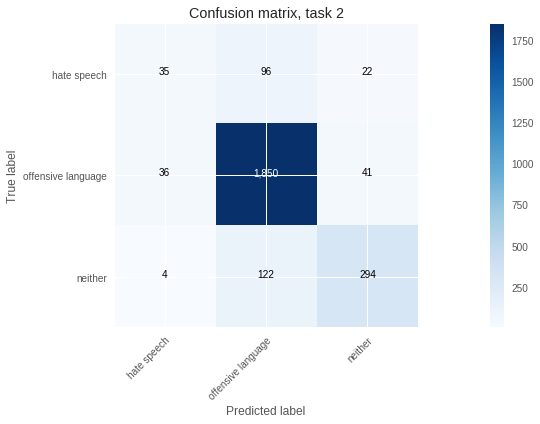

In [27]:
print(color.BOLD + 'Predictions from task 2' + color.END)
print("\n")
print(classification_report(test_y, t2_pred, target_names=labels))
plot_confusion_matrix(test_y, t2_pred, labels, title ="Confusion matrix, task 2")
plt.show()

Predictions from task 3


                    precision    recall  f1-score   support

       hate speech       0.36      0.41      0.39       153
offensive language       0.90      0.93      0.91      1927
           neither       0.81      0.66      0.73       420

       avg / total       0.85      0.85      0.85      2500



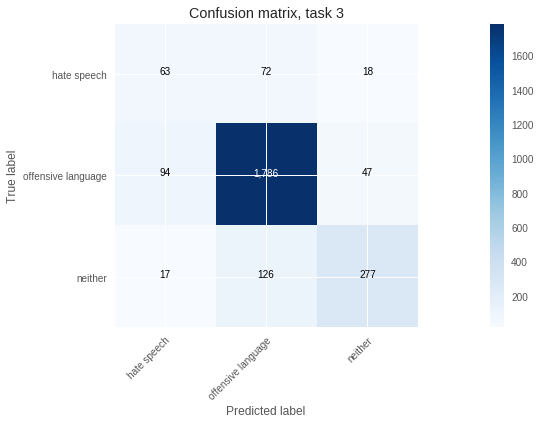

In [28]:
print(color.BOLD + 'Predictions from task 3' + color.END)
print("\n")
print(classification_report(test_y, t3_pred, target_names=labels))
plot_confusion_matrix(test_y, t3_pred, labels, title ="Confusion matrix, task 3")
plt.show()

As we know from task 1.2, our classes are very imbalanced. Therefor it is very important to inspect the errors of the two models.

First of all, the two models tend to produce the same type of errors. In general, both models finds it difficult to classify *hate speech*. But when it comes to classifying *offensive speech* both models are doing a remarkable job.  In fact we see **the model from task two** and **the model from task three** respectively classifying 89% and 90% of the *offensive speech* documents correct. In addition, **the model from task two** is able to predict 96% of the *offensive speech* documents correctly.

However, I find one main differences between the errors produced. If we look at how good the models are at predicting incidents of *hate speech*. We see that **the model from task two** is slightly better at classifying *hate speech*, as it 46% of documents classified as *hate speech* are correct. Though the model only predicted 23% of the *hate speech* documents correctly. On the contrary, we see **the model from task three** predicting 41% of the *hate speech* documents correctly. This might be attributable to the fact, that the model is more prone to predict a document as an incidence of *hate speech*, hence it predicts over twice as many documents to be *hate speech*. Which you could discuss to be preferable, since you might prioritize to flag as many *hate speech* incidents as possible.


## <font color='red'>Assessment 4</font>: Assess Error Analysis (20 pts) 

We will mark the description along the following dimensions: 

* Clarity (5pts: very clear, 0pts: we can't figure out what you did)
* Substance (15pts: good explanation of model errors and differences between the two performances.)

## <font color='blue'>Task 5</font>: Describe your Approaches

Enter a maximum 500 words description of the motivation behind your models (refer back to Tasks 2 and 3), their architecture, and the way you trained and tuned them. In particular, focus on the strengths and weaknesses each type of model has.

*In order to classify documents as hate speech, offensive speech or neither, I have played around with both different models and sets of feature representations.*

#### Task 2
The first step was to perform basic pre-processing, including removing punctuations, whitespaces, stop words etc. While performing different pre-processing steps, I started testing different models in order to see how they each would respond to the diverse input data. The results are listed in table 1. 

                                    Table 1
***
| Model | Train Accc. | Dev Acc. | Filtering | Stop words | Stemming |
|-------|-------------|----------|-----------|------------|----------|
| LR    |    91,21 %  |  86,83 % |    x      |     x      |          |
| LR    |    90,6  %  |  85,41 % |    x      |            |     x    |
| LR    |    90,89 %  |  84,07 % |    x      |     x      |     x    |
| SVC   |    94,92 %  |  86,6  % |    x      |     x      |          |
| SVC   |    94,58 %  |  86,12 % |    x      |            |     x    |
| SVC   |    94,2  %  |  85,9  % |    x      |     x      |     x    |
| NB    |    83,78 %  |  78,56 % |    x      |     x      |          |
| NB    |    82,7  %  |  77,38 % |    x      |            |     x    |
| NB    |    82,57 %  |  76,94 % |    x      |     x      |     x    |
| RF    |    88,35 %  |  85,38 % |    x      |     x      |          |
| RF    |    88,54 %  |  85,86 % |    x      |            |     x    |
| RF    |    87,86 %  |  84,62 % |    x      |     x      |     x    |

After experimenting with several different models; `Naive Bayes`, `Random Forrest`, `Support Vector Machine` and `Logistic Regression`. I choosed to follow Occam's razor principle, since our input data don't contain any categorical values and l1 or l2 regularization can be used to avoid overfitting. Continuing with our best model `Logistic Regression`, I went on to transform the pre-processed text into numerical feature vectors and testing three different sets of feature representations:
- Length of document only
- Unigram term frequncies (count)
- Bigram term frequencies (count)

I started out in the simplest way, by counting the number of tokens for each document. But this approach didn't produce a good accuracy. As we saw in task 1.1, the average number of tokens in a document for each class don't differs much. Instead I tested a bag-of-word model approach, by counting the term frequencies of both unigrams and bigrams. Together with testing different sets of feature representations, I tuned the hyperparameters using `sklearn.grid_search.GridSearchCV` on the training set based on cross-validation. Based on the development accuracy I ended up building a `Logistic Regression` using *l2* regularization with a regularization strength at *1,6* and a *stochastic average gradient* algorithm to minimize the loss function.

                                  Table 2
***
| Feat. Repr.  | Train Accc. | Dev Acc. |   C   | Regularization | Learning rate |
|--------------|-------------|----------|-------|----------------|---------------|
| BOW Unigram  |    91,86 %  |  87,16 % |  1,6  |       L2       |      sag      |
| BOW Bigram   |    91,89 %  |  87,08 % |  1,6  |       L2       |      sag      |
| No of tokens |    81,78 %  |  75,23 % |  0,6  |       L2       |      sag      |


#### Task 3
In task 3 I instead tested the `Logistic Regression` model on three different distributional feature representations:
- TF-IDF
- BERT using both CLS & SEP token
- BERT using only CLS token

Even though I now consider the rareness of a term with TF-IDF, the model doesn't produce a better accuracy. Neither am I able to produce a better accuracy using the vector representation found by the BERT model. This is perhaps due to the different use of language in the training input. As we saw in task 1.5 our training data holds a larger amount of slang words and text abbreviations. Based on the development accuracy I again end up building a `Logistic Regression` using *l2* regularization with a regularization strength at *1,6* and a *stochastic average gradient* algorithm to minimize the loss function.

                                  Table 3
***
| Feat. Repr.    | Train Accc. | Dev Acc. |   C   | Regularization | Learning rate |
|----------------|-------------|----------|-------|----------------|---------------|
| TF-IDF         |    91,62 %  |  85,45 % |  1,6  |       L2       |      sag      |
| BERT (CLS,SEP) |    85,33 %  |  81,08 % |  0,6  |       L2       |      sag      |
| BERT (CLS)     |    86,15 %  |  81,04 % |  0,6  |       L2       |      sag      |

Overall, `Logistic Regression` is easy to implement and fast to train and don't do well with categorical variables, which is not set to be a problem in this project. It is also very good for features that are expected to be linear. In addition, it could propose a disadvantage to this classication problem, as there might be patterns that non-linear models could catch. Another disadvantage to the logistic regression is that does not perform well on too many features. Though, this observation haven't been made in this project.

## <font color='red'>Assessment 5</font>: Assess Description (30 pts) 

We will mark the description along the following dimensions: 

* Clarity (10pts: very clear, 0pts: we can't figure out what you did)
* Creativity (10pts: we could not have come up with this, 0pts: Use the unigram model from the lecture notes)
* Substance (10pts: implemented well motivated hatespeech detection model, 0pts: Use the unigram model from the lecture notes)

The above solution is marked with **
<!-- ASSESSMENT 1: START_POINTS -->
0
<!-- ASSESSMENT 1: END_POINTS --> points**. 